In [1]:
import os
for dirname, _, filenames in os.walk('ds/v2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ds/v2/graph2vec_labels.npy
ds/v2/graph2vec_embeddings.npy


In [36]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, BatchNorm
from collections import defaultdict
import json
import networkx as nx
from torch import nn
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split, KFold

In [9]:
embedding = np.load("/kaggle/input/personalv2/graph2vec_embeddings.npy")
labels = np.load("/kaggle/input/personalv2/graph2vec_labels.npy")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

### Model

In [35]:
class NodeClassificationGNN(nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, num_classes)
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        x = self.mlp(x)
        return x

### lets do cross validation!

In [15]:
def build_similarity_graph(embeddings, threshold):
    num_nodes = embeddings.shape[0]
    similarity_matrix = cosine_similarity(embeddings)

    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, embedding=embeddings[i])

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G

def convert_to_torch_geometric(graph):
    node_features = np.array([graph.nodes[n]['embedding'] for n in graph.nodes])
    edge_index = np.array(list(graph.edges)).T
    edge_weights = np.array([graph[u][v]['weight'] for u, v in graph.edges])

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights)

    return data

def split_data(data, labels, train_ratio=0.7, val_ratio=0.2):
    train_idx, temp_idx, train_labels, temp_labels = train_test_split(
        np.arange(len(labels)), labels, test_size=(1 - train_ratio), stratify=labels
    )
    val_size = val_ratio / (1 - train_ratio)
    val_idx, test_idx, val_labels, test_labels = train_test_split(
        temp_idx, temp_labels, test_size=(1 - val_size), stratify=temp_labels
    )
    return train_idx, val_idx, test_idx

def load_best_model(model, threshold, save_path='checkpoints'):
    checkpoint = torch.load(os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return checkpoint['best_val_loss']

def save_training_history(history, threshold, save_path='training_history'):
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f'history_threshold_{threshold:.2f}.json'), 'w') as f:
        json.dump(history, f, indent=4)

In [16]:
def train_cv(optimizer, criterion, model, data, _, threshold, save_path='checkpoints', num_epochs=300):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                         factor=0.5, patience=10, 
                                                         min_lr=1e-6, verbose=True)
    
    history = defaultdict(list)
    os.makedirs(save_path, exist_ok=True)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
        train_acc = correct / data.train_mask.sum().item()

        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            val_pred = val_out.argmax(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / data.val_mask.sum().item()

        scheduler.step(val_loss)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                  f"Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
    save_training_history(history, threshold)
    
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    return best_val_loss, history


In [21]:
def build_graphs_and_setup_model_cv(embedding, labels, thresholds=np.arange(0.1, 1, 0.1), n_splits=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_avg_test_acc = 0
    all_results = {}

    train_idx, test_idx = train_test_split(
        np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=42
    )

    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask[test_idx] = True
        data.test_mask = test_mask
        data = data.to(device)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_test_accuracies = []

        for fold, (train_sub_idx, val_idx) in enumerate(skf.split(train_idx, labels[train_idx])):
            print(f"  Fold {fold + 1}/{n_splits}")

            train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
            val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)

            train_mask[train_idx[train_sub_idx]] = True
            val_mask[train_idx[val_idx]] = True

            data.train_mask = train_mask
            data.val_mask = val_mask

            # Model and optimizer
            input_dim = 128
            hidden_channels = 256
            out_ch = len(np.unique(labels))
            model = NodeClassificationGNN(
                input_dim=input_dim, hidden_channels=hidden_channels, num_classes=out_ch, dropout=0.5
            ).to(device)
            print(f"Model: input_dim: {input_dim}, hidden_channels: {hidden_channels}, output_dim: {out_ch}")
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
            criterion = torch.nn.CrossEntropyLoss()

            _, history = train_cv(optimizer, criterion, model, data, labels, threshold)
            model.eval()

            # Evaluate on the test set
            with torch.no_grad():
                test_out = model(data.x, data.edge_index)
                test_pred = test_out.argmax(dim=1)
                test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
                test_acc = test_correct / data.test_mask.sum().item()

            print(f"Fold Test Accuracy: {test_acc:.4f}")
            fold_test_accuracies.append(test_acc)

        avg_test_acc = sum(fold_test_accuracies) / n_splits
        print(f"  Average Test Accuracy for Threshold {threshold:.2f}: {avg_test_acc:.4f}")

        all_results[threshold] = {
            'avg_test_accuracy': avg_test_acc,
            'test_accuracies': fold_test_accuracies,
        }
        if avg_test_acc > best_avg_test_acc:
            best_avg_test_acc = avg_test_acc
            best_threshold = threshold

    if not os.path.exists('results'):
        os.makedirs('results')

    with open('results/cv_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_avg_test_accuracy': best_avg_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Average Test Accuracy: {best_avg_test_acc:.4f}")


In [22]:
build_graphs_and_setup_model_cv(embedding, labels)


Training with threshold: 0.1
  Fold 1/5
Model: input_dim: 128, hidden_channels: 256, output_dim: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.5783, Val Loss: 2.5084, Acc: 0.0669, Val Acc: 0.1858
Epoch 10, Loss: 1.7696, Val Loss: 1.5238, Acc: 0.4821, Val Acc: 0.5770
Epoch 20, Loss: 0.9028, Val Loss: 0.5802, Acc: 0.6770, Val Acc: 0.8035
Epoch 30, Loss: 0.5127, Val Loss: 0.2578, Acc: 0.8068, Val Acc: 0.9292
Epoch 40, Loss: 0.2889, Val Loss: 0.1346, Acc: 0.9039, Val Acc: 0.9699
Epoch 50, Loss: 0.1815, Val Loss: 0.0665, Acc: 0.9406, Val Acc: 0.9823
Epoch 60, Loss: 0.1071, Val Loss: 0.0456, Acc: 0.9677, Val Acc: 0.9823
Epoch 70, Loss: 0.0705, Val Loss: 0.0353, Acc: 0.9774, Val Acc: 0.9876
Epoch 80, Loss: 0.0440, Val Loss: 0.0286, Acc: 0.9894, Val Acc: 0.9894
Epoch 90, Loss: 0.0358, Val Loss: 0.0262, Acc: 0.9907, Val Acc: 0.9929
Epoch 100, Loss: 0.0292, Val Loss: 0.0302, Acc: 0.9929, Val Acc: 0.9894
Epoch 110, Loss: 0.0260, Val Loss: 0.0277, Acc: 0.9920, Val Acc: 0.9894
Epoch 120, Loss: 0.0282, Val Loss: 0.0280, Acc: 0.9911, Val Acc: 0.9894
Epoch 130, Loss: 0.0284, Val Loss: 0.0279, Acc: 0.9911, Val Acc: 0.9894
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.5699, Val Loss: 2.5081, Acc: 0.0762, Val Acc: 0.2850
Epoch 10, Loss: 1.6751, Val Loss: 1.3823, Acc: 0.4723, Val Acc: 0.5628
Epoch 20, Loss: 0.8520, Val Loss: 0.5787, Acc: 0.6743, Val Acc: 0.7770
Epoch 30, Loss: 0.4919, Val Loss: 0.2763, Acc: 0.8201, Val Acc: 0.8973
Epoch 40, Loss: 0.3047, Val Loss: 0.1461, Acc: 0.8950, Val Acc: 0.9434
Epoch 50, Loss: 0.1834, Val Loss: 0.0798, Acc: 0.9420, Val Acc: 0.9752
Epoch 60, Loss: 0.1301, Val Loss: 0.0566, Acc: 0.9579, Val Acc: 0.9858
Epoch 70, Loss: 0.0855, Val Loss: 0.0363, Acc: 0.9716, Val Acc: 0.9876
Epoch 80, Loss: 0.0652, Val Loss: 0.0316, Acc: 0.9774, Val Acc: 0.9894
Epoch 90, Loss: 0.0524, Val Loss: 0.0277, Acc: 0.9854, Val Acc: 0.9894
Epoch 100, Loss: 0.0364, Val Loss: 0.0285, Acc: 0.9872, Val Acc: 0.9876
Epoch 110, Loss: 0.0208, Val Loss: 0.0255, Acc: 0.9951, Val Acc: 0.9894
Epoch 120, Loss: 0.0310, Val Loss: 0.0261, Acc: 0.9907, Val Acc: 0.9876
Epoch 130, Loss: 0.0211, Val Loss: 0.0242, Acc: 0.9960, Val Acc: 0.9894
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10, Loss: 1.5025, Val Loss: 1.2202, Acc: 0.5343, Val Acc: 0.6265
Epoch 20, Loss: 0.8015, Val Loss: 0.5582, Acc: 0.6934, Val Acc: 0.7929
Epoch 30, Loss: 0.5191, Val Loss: 0.3112, Acc: 0.8006, Val Acc: 0.8690
Epoch 40, Loss: 0.3332, Val Loss: 0.1906, Acc: 0.8751, Val Acc: 0.9204
Epoch 50, Loss: 0.2217, Val Loss: 0.1179, Acc: 0.9171, Val Acc: 0.9593
Epoch 60, Loss: 0.1464, Val Loss: 0.0859, Acc: 0.9486, Val Acc: 0.9699
Epoch 70, Loss: 0.1054, Val Loss: 0.0669, Acc: 0.9637, Val Acc: 0.9752
Epoch 80, Loss: 0.0839, Val Loss: 0.0571, Acc: 0.9761, Val Acc: 0.9805
Epoch 90, Loss: 0.0662, Val Loss: 0.0449, Acc: 0.9796, Val Acc: 0.9841
Epoch 100, Loss: 0.0438, Val Loss: 0.0396, Acc: 0.9876, Val Acc: 0.9823
Epoch 110, Loss: 0.0424, Val Loss: 0.0380, Acc: 0.9872, Val Acc: 0.9858
Epoch 120, Loss: 0.0288, Val Loss: 0.0444, Acc: 0.9911, Val Acc: 0.9788
Epoch 130, Loss: 0.0181, Val Loss: 0.0345, Acc: 0.9960, Val Acc: 0.9858
Epoch 140, Loss: 0.0249, Val Loss: 0.0347, Acc: 0.9934, Val Acc: 0.9841
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10, Loss: 1.4285, Val Loss: 1.1081, Acc: 0.5445, Val Acc: 0.6354
Epoch 20, Loss: 0.7103, Val Loss: 0.4504, Acc: 0.7302, Val Acc: 0.8336
Epoch 30, Loss: 0.4035, Val Loss: 0.2596, Acc: 0.8498, Val Acc: 0.9062
Epoch 40, Loss: 0.2886, Val Loss: 0.1780, Acc: 0.8963, Val Acc: 0.9416
Epoch 50, Loss: 0.1926, Val Loss: 0.1298, Acc: 0.9349, Val Acc: 0.9558
Epoch 60, Loss: 0.1525, Val Loss: 0.0990, Acc: 0.9424, Val Acc: 0.9699
Epoch 70, Loss: 0.1135, Val Loss: 0.0843, Acc: 0.9566, Val Acc: 0.9752
Epoch 80, Loss: 0.0953, Val Loss: 0.0764, Acc: 0.9659, Val Acc: 0.9788
Epoch 90, Loss: 0.0745, Val Loss: 0.0769, Acc: 0.9743, Val Acc: 0.9770
Epoch 100, Loss: 0.0576, Val Loss: 0.0723, Acc: 0.9805, Val Acc: 0.9823
Epoch 110, Loss: 0.0566, Val Loss: 0.0670, Acc: 0.9818, Val Acc: 0.9788
Epoch 120, Loss: 0.0385, Val Loss: 0.0728, Acc: 0.9876, Val Acc: 0.9788
Epoch 130, Loss: 0.0347, Val Loss: 0.0698, Acc: 0.9894, Val Acc: 0.9823
Epoch 140, Loss: 0.0340, Val Loss: 0.0677, Acc: 0.9903, Val Acc: 0.9823
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 0.9002, Val Loss: 0.6487, Acc: 0.7120, Val Acc: 0.7982
Epoch 30, Loss: 0.5638, Val Loss: 0.3699, Acc: 0.7993, Val Acc: 0.9027
Epoch 40, Loss: 0.3821, Val Loss: 0.2453, Acc: 0.8684, Val Acc: 0.9292
Epoch 50, Loss: 0.2605, Val Loss: 0.1833, Acc: 0.9114, Val Acc: 0.9416
Epoch 60, Loss: 0.2020, Val Loss: 0.1475, Acc: 0.9300, Val Acc: 0.9504
Epoch 70, Loss: 0.1591, Val Loss: 0.1261, Acc: 0.9451, Val Acc: 0.9540
Epoch 80, Loss: 0.1226, Val Loss: 0.1113, Acc: 0.9597, Val Acc: 0.9611
Epoch 90, Loss: 0.0912, Val Loss: 0.1149, Acc: 0.9699, Val Acc: 0.9664
Epoch 100, Loss: 0.0919, Val Loss: 0.1034, Acc: 0.9681, Val Acc: 0.9628
Epoch 110, Loss: 0.0772, Val Loss: 0.1065, Acc: 0.9752, Val Acc: 0.9681
Epoch 120, Loss: 0.0809, Val Loss: 0.1039, Acc: 0.9739, Val Acc: 0.9699
Epoch 130, Loss: 0.0687, Val Loss: 0.1054, Acc: 0.9756, Val Acc: 0.9699
Epoch 140, Loss: 0.0712, Val Loss: 0.1068, Acc: 0.9752, Val Acc: 0.9664
Epoch 150, Loss: 0.0600, Val Loss: 0.1076, Acc: 0.9796, Val Acc: 0.9646


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.0587, Val Loss: 0.7625, Acc: 0.6526, Val Acc: 0.7221
Epoch 30, Loss: 0.6228, Val Loss: 0.4132, Acc: 0.7820, Val Acc: 0.8637
Epoch 40, Loss: 0.4077, Val Loss: 0.2759, Acc: 0.8578, Val Acc: 0.9204
Epoch 50, Loss: 0.2967, Val Loss: 0.2190, Acc: 0.9025, Val Acc: 0.9327
Epoch 60, Loss: 0.2334, Val Loss: 0.1845, Acc: 0.9189, Val Acc: 0.9416
Epoch 70, Loss: 0.1844, Val Loss: 0.1641, Acc: 0.9393, Val Acc: 0.9451
Epoch 80, Loss: 0.1439, Val Loss: 0.1624, Acc: 0.9477, Val Acc: 0.9522
Epoch 90, Loss: 0.1225, Val Loss: 0.1541, Acc: 0.9570, Val Acc: 0.9558
Epoch 100, Loss: 0.0893, Val Loss: 0.1545, Acc: 0.9708, Val Acc: 0.9540
Epoch 110, Loss: 0.0870, Val Loss: 0.1611, Acc: 0.9703, Val Acc: 0.9504
Epoch 120, Loss: 0.0801, Val Loss: 0.1618, Acc: 0.9716, Val Acc: 0.9540
Epoch 130, Loss: 0.0793, Val Loss: 0.1593, Acc: 0.9739, Val Acc: 0.9558
Epoch 140, Loss: 0.0806, Val Loss: 0.1618, Acc: 0.9752, Val Acc: 0.9593
Epoch 150, Loss: 0.0617, Val Loss: 0.1627, Acc: 0.9805, Val Acc: 0.9540


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.1428, Val Loss: 0.8888, Acc: 0.6207, Val Acc: 0.6779
Epoch 30, Loss: 0.6878, Val Loss: 0.4770, Acc: 0.7421, Val Acc: 0.8177
Epoch 40, Loss: 0.4649, Val Loss: 0.3145, Acc: 0.8339, Val Acc: 0.8938
Epoch 50, Loss: 0.3350, Val Loss: 0.2212, Acc: 0.8928, Val Acc: 0.9186
Epoch 60, Loss: 0.2583, Val Loss: 0.1820, Acc: 0.9132, Val Acc: 0.9310
Epoch 70, Loss: 0.1949, Val Loss: 0.1637, Acc: 0.9362, Val Acc: 0.9363
Epoch 80, Loss: 0.1653, Val Loss: 0.1565, Acc: 0.9464, Val Acc: 0.9381
Epoch 90, Loss: 0.1502, Val Loss: 0.1502, Acc: 0.9464, Val Acc: 0.9451
Epoch 100, Loss: 0.1282, Val Loss: 0.1491, Acc: 0.9566, Val Acc: 0.9398
Epoch 110, Loss: 0.1006, Val Loss: 0.1568, Acc: 0.9654, Val Acc: 0.9434
Epoch 120, Loss: 0.0987, Val Loss: 0.1611, Acc: 0.9672, Val Acc: 0.9416
Epoch 130, Loss: 0.0906, Val Loss: 0.1610, Acc: 0.9699, Val Acc: 0.9416
Epoch 140, Loss: 0.0894, Val Loss: 0.1613, Acc: 0.9734, Val Acc: 0.9416
Epoch 150, Loss: 0.0950, Val Loss: 0.1594, Acc: 0.9677, Val Acc: 0.9416


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.0910, Val Loss: 0.8375, Acc: 0.6318, Val Acc: 0.6956
Epoch 30, Loss: 0.6613, Val Loss: 0.4291, Acc: 0.7563, Val Acc: 0.8690
Epoch 40, Loss: 0.4794, Val Loss: 0.2833, Acc: 0.8325, Val Acc: 0.9150
Epoch 50, Loss: 0.3253, Val Loss: 0.2172, Acc: 0.8799, Val Acc: 0.9327
Epoch 60, Loss: 0.2549, Val Loss: 0.1811, Acc: 0.9056, Val Acc: 0.9363
Epoch 70, Loss: 0.2234, Val Loss: 0.1645, Acc: 0.9216, Val Acc: 0.9434
Epoch 80, Loss: 0.1967, Val Loss: 0.1478, Acc: 0.9371, Val Acc: 0.9540
Epoch 90, Loss: 0.1661, Val Loss: 0.1438, Acc: 0.9420, Val Acc: 0.9522
Epoch 100, Loss: 0.1298, Val Loss: 0.1485, Acc: 0.9535, Val Acc: 0.9469
Epoch 110, Loss: 0.1280, Val Loss: 0.1400, Acc: 0.9592, Val Acc: 0.9558
Epoch 120, Loss: 0.1190, Val Loss: 0.1466, Acc: 0.9606, Val Acc: 0.9469
Epoch 130, Loss: 0.1141, Val Loss: 0.1427, Acc: 0.9646, Val Acc: 0.9540
Epoch 140, Loss: 0.1121, Val Loss: 0.1436, Acc: 0.9663, Val Acc: 0.9540
Epoch 150, Loss: 0.1001, Val Loss: 0.1428, Acc: 0.9650, Val Acc: 0.9540


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.0833, Val Loss: 0.8247, Acc: 0.6389, Val Acc: 0.7416
Epoch 30, Loss: 0.6840, Val Loss: 0.4593, Acc: 0.7399, Val Acc: 0.8372
Epoch 40, Loss: 0.4695, Val Loss: 0.3263, Acc: 0.8268, Val Acc: 0.8814
Epoch 50, Loss: 0.3666, Val Loss: 0.2524, Acc: 0.8720, Val Acc: 0.9204
Epoch 60, Loss: 0.2858, Val Loss: 0.2039, Acc: 0.8999, Val Acc: 0.9345
Epoch 70, Loss: 0.2331, Val Loss: 0.1743, Acc: 0.9092, Val Acc: 0.9416
Epoch 80, Loss: 0.1938, Val Loss: 0.1476, Acc: 0.9313, Val Acc: 0.9469
Epoch 90, Loss: 0.1645, Val Loss: 0.1486, Acc: 0.9477, Val Acc: 0.9504
Epoch 100, Loss: 0.1478, Val Loss: 0.1409, Acc: 0.9557, Val Acc: 0.9522
Epoch 110, Loss: 0.1486, Val Loss: 0.1444, Acc: 0.9499, Val Acc: 0.9558
Epoch 120, Loss: 0.1160, Val Loss: 0.1365, Acc: 0.9588, Val Acc: 0.9575
Epoch 130, Loss: 0.1237, Val Loss: 0.1393, Acc: 0.9628, Val Acc: 0.9558
Epoch 140, Loss: 0.1077, Val Loss: 0.1385, Acc: 0.9646, Val Acc: 0.9540
Epoch 150, Loss: 0.0951, Val Loss: 0.1406, Acc: 0.9699, Val Acc: 0.9540


In [23]:
import json
#Load overall_results.json
with open('results/cv_results.json', 'r') as f:
    results = json.load(f)

best_threshold = results['best_threshold']
best_test_accuracy = results['best_avg_test_accuracy']
all_thresholds_results = results['all_thresholds_results']

### oof is this real chat?

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


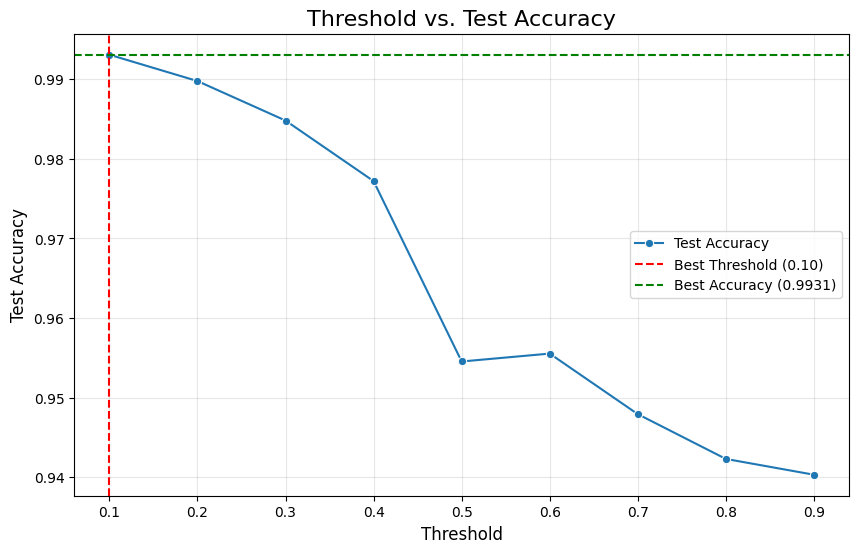

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [float(k) for k in all_thresholds_results.keys()]
test_accuracies = [v['avg_test_accuracy'] for v in all_thresholds_results.values()]
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=test_accuracies, marker="o", label="Test Accuracy")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold ({best_threshold:.2f})")
plt.axhline(best_test_accuracy, color='green', linestyle='--', label=f"Best Accuracy ({best_test_accuracy:.4f})")
plt.title("Threshold vs. Test Accuracy", fontsize=16)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


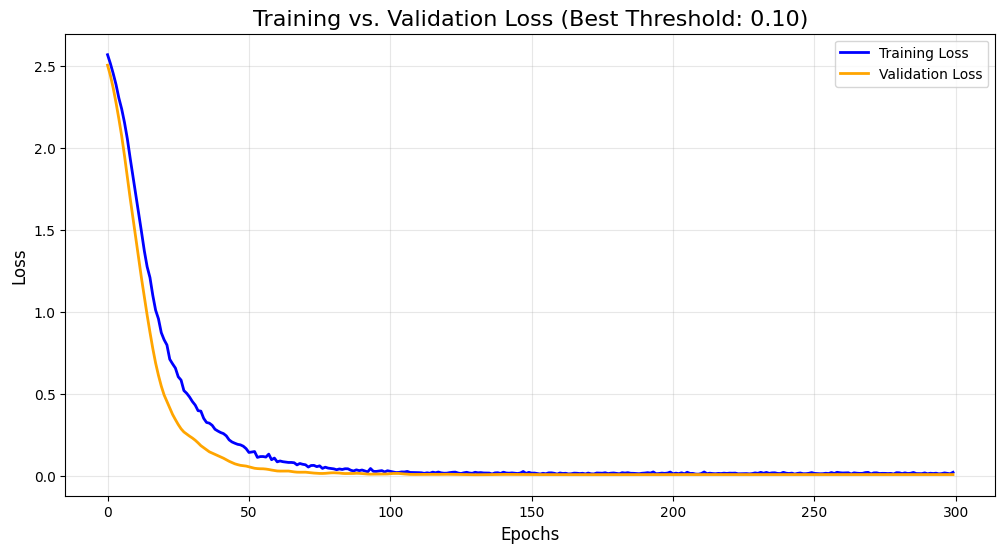

In [30]:
file = "training_history/history_threshold_0.10.json"
with open(file, 'r') as f:
    best_history = json.load(f)


train_losses = best_history['train_loss']
val_losses = best_history['val_loss']
epochs = range(len(train_losses))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Training Loss", color='blue', linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", color='orange', linewidth=2)
plt.title(f"Training vs. Validation Loss (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


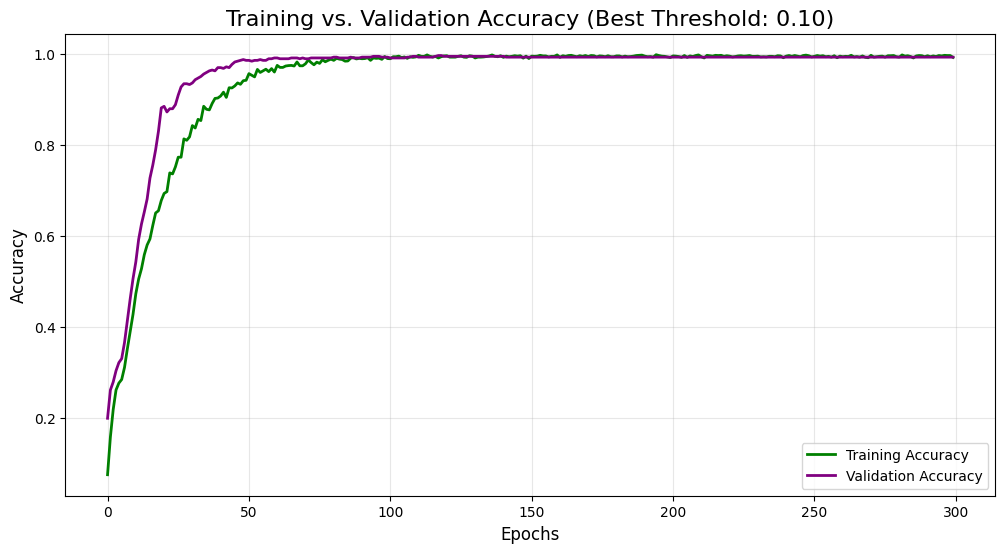

In [31]:
train_acc = best_history['train_acc']
val_acc = best_history['val_acc']
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label="Training Accuracy", color='green', linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", color='purple', linewidth=2)
plt.title(f"Training vs. Validation Accuracy (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


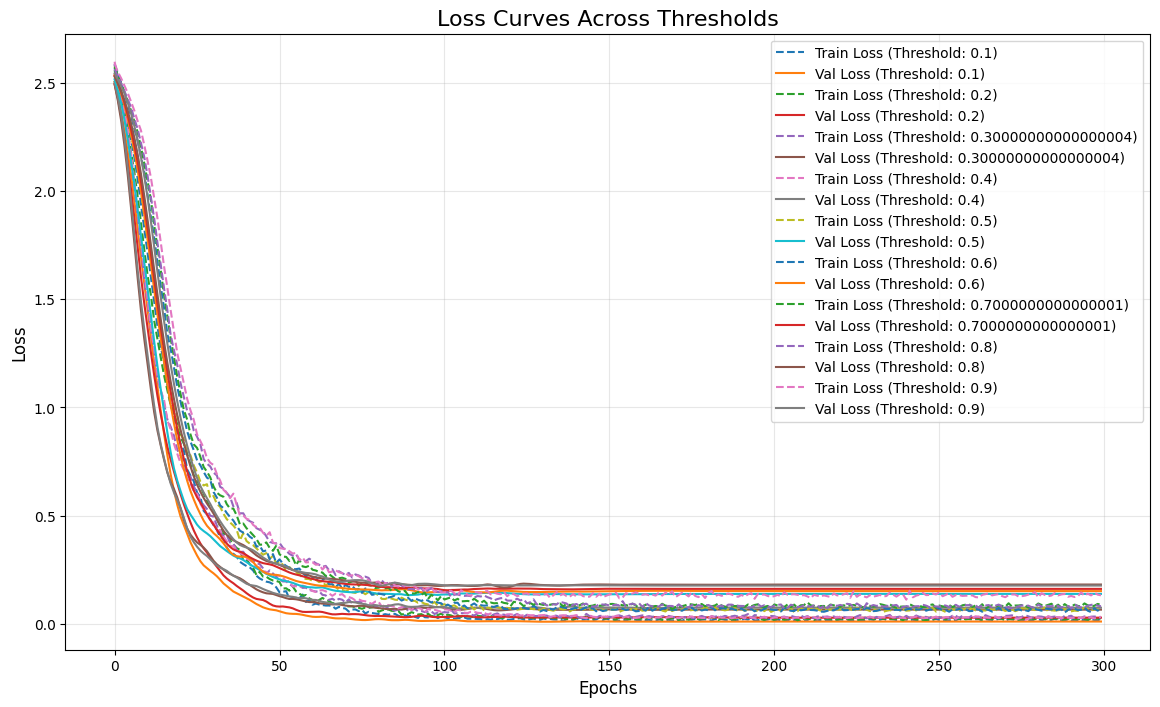

In [33]:
import numpy as np
plt.figure(figsize=(14, 8))

train_info = {}
val_info = {}
for i in np.arange(0.1, 1, 0.1):
    with open(f'training_history/history_threshold_{i:.2f}.json', 'r') as f:
        best_history = json.load(f)
    train_info[i] = best_history['train_loss']
    val_info[i] = best_history['val_loss']            
        
for (k1, v1), (k2, v2) in zip(train_info.items(), val_info.items()):
    train_loss = v1
    val_loss = v2
    plt.plot(train_loss, label=f"Train Loss (Threshold: {k1})", linestyle='--')
    plt.plot(val_loss, label=f"Val Loss (Threshold: {k1})", linestyle='-')

plt.title("Loss Curves Across Thresholds", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.show()


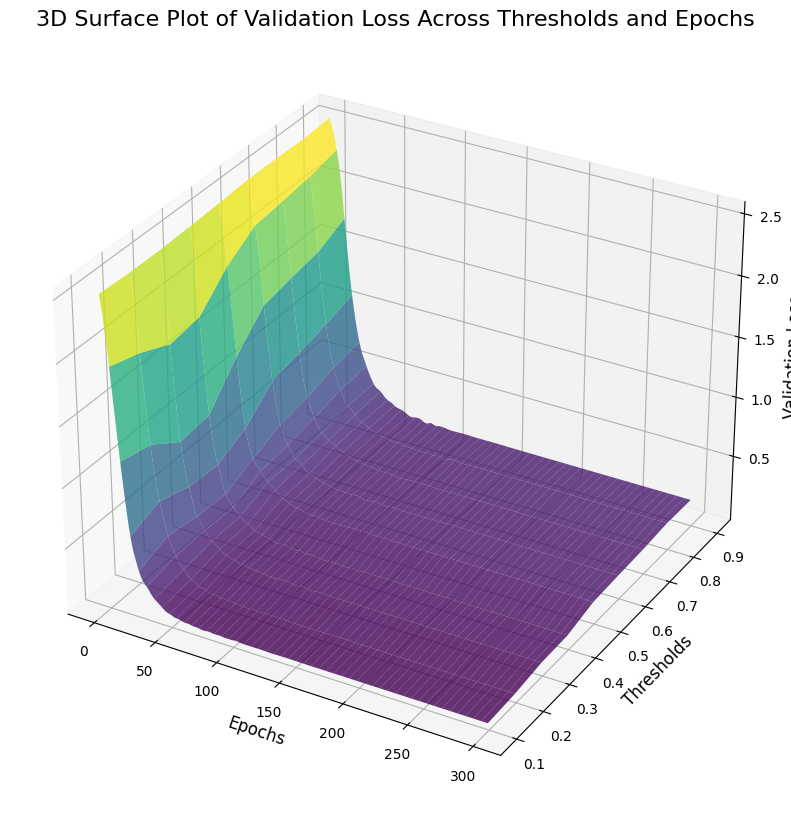

In [34]:
from mpl_toolkits.mplot3d import Axes3D

thresholds = np.array([t for t in thresholds])
epochs = np.arange(len(train_losses))
X, Y = np.meshgrid(epochs, thresholds)
Z = np.array([val_info[threshold] for threshold in thresholds])
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.8)
ax.set_title("3D Surface Plot of Validation Loss Across Thresholds and Epochs", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Thresholds", fontsize=12)
ax.set_zlabel("Validation Loss", fontsize=12)
plt.show()


In [37]:
# download the amazing results
import shutil
shutil.make_archive('working_dir', 'zip', '/kaggle/working')

'/kaggle/working/working_dir.zip'

### lets do a sanity without stratifying the dataset? It should not work as well right?

Our dataset is not equally distributed among all labels

In [38]:
def build_graphs_and_setup_model_cv_non_stratified(embedding, labels, thresholds=np.arange(0.1, 1, 0.1), n_splits=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_avg_test_acc = 0
    all_results = {}

    train_idx, test_idx = train_test_split(
        np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=42
    )

    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask[test_idx] = True
        data.test_mask = test_mask
        data = data.to(device)

        # regular kfold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_test_accuracies = []

        for fold, (train_sub_idx, val_idx) in enumerate(kf.split(train_idx, labels[train_idx])):
            print(f"  Fold {fold + 1}/{n_splits}")

            train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
            val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)

            train_mask[train_idx[train_sub_idx]] = True
            val_mask[train_idx[val_idx]] = True

            data.train_mask = train_mask
            data.val_mask = val_mask

            # Model and optimizer
            input_dim = 128
            hidden_channels = 256
            out_ch = len(np.unique(labels))
            model = NodeClassificationGNN(
                input_dim=input_dim, hidden_channels=hidden_channels, num_classes=out_ch, dropout=0.5
            ).to(device)
            print(f"Model: input_dim: {input_dim}, hidden_channels: {hidden_channels}, output_dim: {out_ch}")
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
            criterion = torch.nn.CrossEntropyLoss()

            _, history = train_cv(optimizer, criterion, model, data, labels, threshold)
            model.eval()

            # Evaluate on the test set
            with torch.no_grad():
                test_out = model(data.x, data.edge_index)
                test_pred = test_out.argmax(dim=1)
                test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
                test_acc = test_correct / data.test_mask.sum().item()

            print(f"Fold Test Accuracy: {test_acc:.4f}")
            fold_test_accuracies.append(test_acc)

        avg_test_acc = sum(fold_test_accuracies) / n_splits
        print(f"  Average Test Accuracy for Threshold {threshold:.2f}: {avg_test_acc:.4f}")

        all_results[threshold] = {
            'avg_test_accuracy': avg_test_acc,
            'test_accuracies': fold_test_accuracies,
        }
        if avg_test_acc > best_avg_test_acc:
            best_avg_test_acc = avg_test_acc
            best_threshold = threshold

    if not os.path.exists('results'):
        os.makedirs('results')

    with open('results/cv_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_avg_test_accuracy': best_avg_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Average Test Accuracy: {best_avg_test_acc:.4f}")


In [39]:
build_graphs_and_setup_model_cv_non_stratified(embedding, labels)


Training with threshold: 0.1
  Fold 1/5
Model: input_dim: 128, hidden_channels: 256, output_dim: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.5917, Val Loss: 2.5206, Acc: 0.0687, Val Acc: 0.2584
Epoch 10, Loss: 1.8397, Val Loss: 1.5920, Acc: 0.4386, Val Acc: 0.5522
Epoch 20, Loss: 0.8831, Val Loss: 0.5668, Acc: 0.6779, Val Acc: 0.8248
Epoch 30, Loss: 0.4977, Val Loss: 0.2541, Acc: 0.8068, Val Acc: 0.9381
Epoch 40, Loss: 0.2792, Val Loss: 0.1224, Acc: 0.9056, Val Acc: 0.9558
Epoch 50, Loss: 0.1641, Val Loss: 0.0628, Acc: 0.9433, Val Acc: 0.9788
Epoch 60, Loss: 0.0912, Val Loss: 0.0440, Acc: 0.9712, Val Acc: 0.9858
Epoch 70, Loss: 0.0681, Val Loss: 0.0287, Acc: 0.9796, Val Acc: 0.9929
Epoch 80, Loss: 0.0622, Val Loss: 0.0300, Acc: 0.9832, Val Acc: 0.9912
Epoch 90, Loss: 0.0411, Val Loss: 0.0220, Acc: 0.9898, Val Acc: 0.9912
Epoch 100, Loss: 0.0259, Val Loss: 0.0233, Acc: 0.9934, Val Acc: 0.9929
Epoch 110, Loss: 0.0216, Val Loss: 0.0206, Acc: 0.9929, Val Acc: 0.9929
Epoch 120, Loss: 0.0220, Val Loss: 0.0176, Acc: 0.9925, Val Acc: 0.9929
Epoch 130, Loss: 0.0173, Val Loss: 0.0147, Acc: 0.9960, Val Acc: 0.9947
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.5645, Val Loss: 2.5062, Acc: 0.0749, Val Acc: 0.2018
Epoch 10, Loss: 1.6936, Val Loss: 1.4297, Acc: 0.4829, Val Acc: 0.5628
Epoch 20, Loss: 0.8439, Val Loss: 0.5556, Acc: 0.6695, Val Acc: 0.7929
Epoch 30, Loss: 0.4773, Val Loss: 0.2565, Acc: 0.8241, Val Acc: 0.9274
Epoch 40, Loss: 0.3037, Val Loss: 0.1318, Acc: 0.8883, Val Acc: 0.9593
Epoch 50, Loss: 0.1704, Val Loss: 0.0779, Acc: 0.9451, Val Acc: 0.9735
Epoch 60, Loss: 0.1120, Val Loss: 0.0433, Acc: 0.9615, Val Acc: 0.9876
Epoch 70, Loss: 0.0810, Val Loss: 0.0421, Acc: 0.9734, Val Acc: 0.9858
Epoch 80, Loss: 0.0591, Val Loss: 0.0309, Acc: 0.9832, Val Acc: 0.9912
Epoch 90, Loss: 0.0427, Val Loss: 0.0245, Acc: 0.9885, Val Acc: 0.9929
Epoch 100, Loss: 0.0425, Val Loss: 0.0231, Acc: 0.9845, Val Acc: 0.9912
Epoch 110, Loss: 0.0366, Val Loss: 0.0215, Acc: 0.9889, Val Acc: 0.9929
Epoch 120, Loss: 0.0243, Val Loss: 0.0248, Acc: 0.9938, Val Acc: 0.9929
Epoch 130, Loss: 0.0246, Val Loss: 0.0181, Acc: 0.9947, Val Acc: 0.9929
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10, Loss: 1.5763, Val Loss: 1.3066, Acc: 0.4891, Val Acc: 0.5982
Epoch 20, Loss: 0.8198, Val Loss: 0.5664, Acc: 0.6912, Val Acc: 0.7646
Epoch 30, Loss: 0.5010, Val Loss: 0.2897, Acc: 0.8090, Val Acc: 0.8973
Epoch 40, Loss: 0.3091, Val Loss: 0.1746, Acc: 0.8875, Val Acc: 0.9381
Epoch 50, Loss: 0.2151, Val Loss: 0.1166, Acc: 0.9251, Val Acc: 0.9575
Epoch 60, Loss: 0.1489, Val Loss: 0.0781, Acc: 0.9473, Val Acc: 0.9752
Epoch 70, Loss: 0.1163, Val Loss: 0.0566, Acc: 0.9628, Val Acc: 0.9841
Epoch 80, Loss: 0.0890, Val Loss: 0.0447, Acc: 0.9712, Val Acc: 0.9858
Epoch 90, Loss: 0.0645, Val Loss: 0.0360, Acc: 0.9818, Val Acc: 0.9912
Epoch 100, Loss: 0.0459, Val Loss: 0.0358, Acc: 0.9867, Val Acc: 0.9894
Epoch 110, Loss: 0.0358, Val Loss: 0.0336, Acc: 0.9894, Val Acc: 0.9912
Epoch 120, Loss: 0.0345, Val Loss: 0.0328, Acc: 0.9903, Val Acc: 0.9894
Epoch 130, Loss: 0.0247, Val Loss: 0.0342, Acc: 0.9947, Val Acc: 0.9894
Epoch 140, Loss: 0.0214, Val Loss: 0.0317, Acc: 0.9942, Val Acc: 0.9894
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10, Loss: 1.4792, Val Loss: 1.1993, Acc: 0.5295, Val Acc: 0.6106
Epoch 20, Loss: 0.7788, Val Loss: 0.5005, Acc: 0.7009, Val Acc: 0.8018
Epoch 30, Loss: 0.4521, Val Loss: 0.2543, Acc: 0.8312, Val Acc: 0.9097
Epoch 40, Loss: 0.2645, Val Loss: 0.1789, Acc: 0.9056, Val Acc: 0.9381
Epoch 50, Loss: 0.2042, Val Loss: 0.1428, Acc: 0.9256, Val Acc: 0.9487
Epoch 60, Loss: 0.1455, Val Loss: 0.1097, Acc: 0.9477, Val Acc: 0.9681
Epoch 70, Loss: 0.1016, Val Loss: 0.1103, Acc: 0.9663, Val Acc: 0.9611
Epoch 80, Loss: 0.0857, Val Loss: 0.0833, Acc: 0.9712, Val Acc: 0.9788
Epoch 90, Loss: 0.0739, Val Loss: 0.0876, Acc: 0.9778, Val Acc: 0.9735
Epoch 100, Loss: 0.0586, Val Loss: 0.0917, Acc: 0.9801, Val Acc: 0.9770
Epoch 110, Loss: 0.0487, Val Loss: 0.0892, Acc: 0.9823, Val Acc: 0.9805
Epoch 120, Loss: 0.0478, Val Loss: 0.0869, Acc: 0.9845, Val Acc: 0.9805
Epoch 130, Loss: 0.0403, Val Loss: 0.0890, Acc: 0.9885, Val Acc: 0.9770
Epoch 140, Loss: 0.0440, Val Loss: 0.0808, Acc: 0.9840, Val Acc: 0.9805
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 0.9023, Val Loss: 0.6257, Acc: 0.6876, Val Acc: 0.8106
Epoch 30, Loss: 0.5568, Val Loss: 0.3775, Acc: 0.7975, Val Acc: 0.8761
Epoch 40, Loss: 0.4077, Val Loss: 0.2725, Acc: 0.8573, Val Acc: 0.8973
Epoch 50, Loss: 0.2698, Val Loss: 0.2078, Acc: 0.9083, Val Acc: 0.9239
Epoch 60, Loss: 0.1943, Val Loss: 0.1726, Acc: 0.9296, Val Acc: 0.9363
Epoch 70, Loss: 0.1516, Val Loss: 0.1444, Acc: 0.9490, Val Acc: 0.9469
Epoch 80, Loss: 0.1325, Val Loss: 0.1415, Acc: 0.9544, Val Acc: 0.9451
Epoch 90, Loss: 0.1051, Val Loss: 0.1370, Acc: 0.9672, Val Acc: 0.9487
Epoch 100, Loss: 0.1133, Val Loss: 0.1390, Acc: 0.9615, Val Acc: 0.9469
Epoch 110, Loss: 0.0983, Val Loss: 0.1358, Acc: 0.9641, Val Acc: 0.9540
Epoch 120, Loss: 0.0947, Val Loss: 0.1325, Acc: 0.9663, Val Acc: 0.9469
Epoch 130, Loss: 0.1024, Val Loss: 0.1364, Acc: 0.9659, Val Acc: 0.9487
Epoch 140, Loss: 0.0765, Val Loss: 0.1324, Acc: 0.9770, Val Acc: 0.9522
Epoch 150, Loss: 0.0823, Val Loss: 0.1338, Acc: 0.9721, Val Acc: 0.9540


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.0516, Val Loss: 0.7750, Acc: 0.6402, Val Acc: 0.7469
Epoch 30, Loss: 0.6149, Val Loss: 0.3941, Acc: 0.7882, Val Acc: 0.8637
Epoch 40, Loss: 0.3967, Val Loss: 0.2847, Acc: 0.8556, Val Acc: 0.9080
Epoch 50, Loss: 0.2822, Val Loss: 0.2132, Acc: 0.9016, Val Acc: 0.9327
Epoch 60, Loss: 0.2056, Val Loss: 0.1858, Acc: 0.9282, Val Acc: 0.9398
Epoch 70, Loss: 0.1775, Val Loss: 0.1682, Acc: 0.9380, Val Acc: 0.9469
Epoch 80, Loss: 0.1266, Val Loss: 0.1605, Acc: 0.9544, Val Acc: 0.9522
Epoch 90, Loss: 0.0958, Val Loss: 0.1527, Acc: 0.9681, Val Acc: 0.9540
Epoch 100, Loss: 0.0896, Val Loss: 0.1595, Acc: 0.9703, Val Acc: 0.9558
Epoch 110, Loss: 0.0895, Val Loss: 0.1567, Acc: 0.9721, Val Acc: 0.9540
Epoch 120, Loss: 0.0842, Val Loss: 0.1562, Acc: 0.9721, Val Acc: 0.9522
Epoch 130, Loss: 0.0663, Val Loss: 0.1576, Acc: 0.9765, Val Acc: 0.9522
Epoch 140, Loss: 0.0764, Val Loss: 0.1587, Acc: 0.9796, Val Acc: 0.9540
Epoch 150, Loss: 0.0699, Val Loss: 0.1592, Acc: 0.9752, Val Acc: 0.9540


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.0988, Val Loss: 0.8671, Acc: 0.6221, Val Acc: 0.7097
Epoch 30, Loss: 0.6623, Val Loss: 0.4650, Acc: 0.7599, Val Acc: 0.8106
Epoch 40, Loss: 0.4238, Val Loss: 0.2963, Acc: 0.8436, Val Acc: 0.8956
Epoch 50, Loss: 0.3128, Val Loss: 0.2139, Acc: 0.8906, Val Acc: 0.9327
Epoch 60, Loss: 0.2486, Val Loss: 0.1689, Acc: 0.9136, Val Acc: 0.9434
Epoch 70, Loss: 0.1883, Val Loss: 0.1428, Acc: 0.9437, Val Acc: 0.9469
Epoch 80, Loss: 0.1541, Val Loss: 0.1384, Acc: 0.9455, Val Acc: 0.9504
Epoch 90, Loss: 0.1433, Val Loss: 0.1373, Acc: 0.9486, Val Acc: 0.9522
Epoch 100, Loss: 0.1164, Val Loss: 0.1376, Acc: 0.9592, Val Acc: 0.9558
Epoch 110, Loss: 0.1045, Val Loss: 0.1297, Acc: 0.9694, Val Acc: 0.9611
Epoch 120, Loss: 0.0987, Val Loss: 0.1394, Acc: 0.9650, Val Acc: 0.9522
Epoch 130, Loss: 0.0913, Val Loss: 0.1325, Acc: 0.9743, Val Acc: 0.9593
Epoch 140, Loss: 0.0935, Val Loss: 0.1355, Acc: 0.9725, Val Acc: 0.9558
Epoch 150, Loss: 0.0811, Val Loss: 0.1353, Acc: 0.9756, Val Acc: 0.9558


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.1707, Val Loss: 0.9119, Acc: 0.5862, Val Acc: 0.6513
Epoch 30, Loss: 0.7361, Val Loss: 0.4962, Acc: 0.7355, Val Acc: 0.8071
Epoch 40, Loss: 0.5259, Val Loss: 0.3248, Acc: 0.8064, Val Acc: 0.8956
Epoch 50, Loss: 0.3717, Val Loss: 0.2281, Acc: 0.8751, Val Acc: 0.9310
Epoch 60, Loss: 0.2898, Val Loss: 0.1856, Acc: 0.8959, Val Acc: 0.9345
Epoch 70, Loss: 0.2379, Val Loss: 0.1693, Acc: 0.9132, Val Acc: 0.9345
Epoch 80, Loss: 0.1952, Val Loss: 0.1581, Acc: 0.9287, Val Acc: 0.9381
Epoch 90, Loss: 0.1589, Val Loss: 0.1477, Acc: 0.9486, Val Acc: 0.9434
Epoch 100, Loss: 0.1373, Val Loss: 0.1476, Acc: 0.9553, Val Acc: 0.9416
Epoch 110, Loss: 0.1214, Val Loss: 0.1488, Acc: 0.9623, Val Acc: 0.9434
Epoch 120, Loss: 0.1320, Val Loss: 0.1511, Acc: 0.9610, Val Acc: 0.9416
Epoch 130, Loss: 0.1263, Val Loss: 0.1474, Acc: 0.9584, Val Acc: 0.9434
Epoch 140, Loss: 0.1275, Val Loss: 0.1478, Acc: 0.9588, Val Acc: 0.9416
Epoch 150, Loss: 0.1084, Val Loss: 0.1512, Acc: 0.9699, Val Acc: 0.9434


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20, Loss: 1.1823, Val Loss: 0.9019, Acc: 0.6061, Val Acc: 0.6903
Epoch 30, Loss: 0.7096, Val Loss: 0.4594, Acc: 0.7541, Val Acc: 0.8248
Epoch 40, Loss: 0.4744, Val Loss: 0.2980, Acc: 0.8316, Val Acc: 0.9062
Epoch 50, Loss: 0.3514, Val Loss: 0.2238, Acc: 0.8804, Val Acc: 0.9274
Epoch 60, Loss: 0.2842, Val Loss: 0.1790, Acc: 0.9039, Val Acc: 0.9434
Epoch 70, Loss: 0.2143, Val Loss: 0.1631, Acc: 0.9256, Val Acc: 0.9469
Epoch 80, Loss: 0.1982, Val Loss: 0.1514, Acc: 0.9340, Val Acc: 0.9416
Epoch 90, Loss: 0.1584, Val Loss: 0.1506, Acc: 0.9446, Val Acc: 0.9434
Epoch 100, Loss: 0.1389, Val Loss: 0.1380, Acc: 0.9535, Val Acc: 0.9451
Epoch 110, Loss: 0.1505, Val Loss: 0.1448, Acc: 0.9486, Val Acc: 0.9451
Epoch 120, Loss: 0.1165, Val Loss: 0.1388, Acc: 0.9601, Val Acc: 0.9469
Epoch 130, Loss: 0.1049, Val Loss: 0.1359, Acc: 0.9694, Val Acc: 0.9469
Epoch 140, Loss: 0.1114, Val Loss: 0.1373, Acc: 0.9677, Val Acc: 0.9504
Epoch 150, Loss: 0.1063, Val Loss: 0.1382, Acc: 0.9623, Val Acc: 0.9504


## Similar results? What in the abracadabra :cry: ?

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


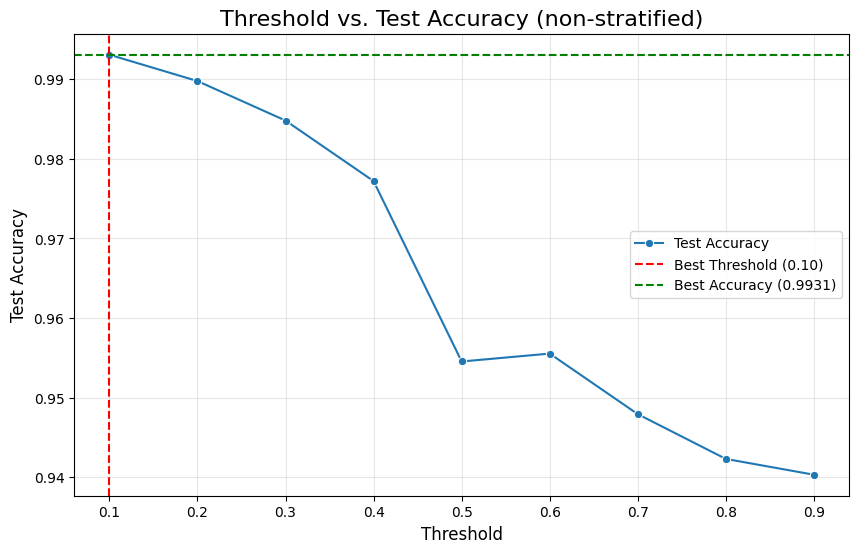

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [float(k) for k in all_thresholds_results.keys()]
test_accuracies = [v['avg_test_accuracy'] for v in all_thresholds_results.values()]
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=test_accuracies, marker="o", label="Test Accuracy")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold ({best_threshold:.2f})")
plt.axhline(best_test_accuracy, color='green', linestyle='--', label=f"Best Accuracy ({best_test_accuracy:.4f})")
plt.title("Threshold vs. Test Accuracy (non-stratified)", fontsize=16)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()
